In [49]:
%pylab inline
import numpy as np
import scipy as sc
import pandas as pd
from ABC_algorithm import ABC

import statsmodels as sm
from sklearn.linear_model import LinearRegression

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [61]:
######
# set up for the normal ABC example
######

prior_mean = -4.0
prior_sd = 3
likelihood_sd = 1

def NormalPriorSampler(n):
    return np.random.normal(loc=prior_mean, scale=prior_sd, size=n)

def NormalLiklihoodSimulator(n, param):
    #unknown mean
    return np.random.normal(loc=param, scale=likelihood_sd, size=n)
    
def NormalSummary(data):
    return np.mean(data, axis=0)

data = np.random.normal(loc=0,scale=likelihood_sd,size=5)

post_sd = np.power((1.0/np.power(prior_sd,2) + len(data)/np.power(likelihood_sd,2)),-1/2)
post_mean = (prior_mean/np.power(prior_sd,2) + np.sum(data)/(np.power(likelihood_sd,2)))/(1/np.power(prior_sd,2) + len(data)/np.power(likelihood_sd,2))
print post_mean, "is posterior mean"
print post_sd, "is posterior std dev"

df = ABC(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, 0.5, data, 1000)

-1.00796685062 is posterior mean
0.195652173913 is posterior std dev


In [62]:
def EpanechnikovKernel(t,delta,c=1):
    if t<=delta:
        return c*(1/delta)*(1-(t/delta)**2)
    else:
        return 0

## A function for post processing ABC algorithm output

In [103]:
def post_process(abc_df):
    """
    Given a dataframe output to ABC, return dataframe with accepted thetas transformed in column "theta_star"
    """
    # take accpted values output from ABC
    df_accepted = abc_df[abc_df['accept'] == 1]

    #print df_accepted.head()

    # do weighted linear regresions

    df_accepted.statistics_diff = df_accepted.statistics - NormalSummary(data)
    df_accepted.statistics_diff_abs = df_accepted.statistics_diff.apply(lambda x: abs(x))

    #df_accepted.statistics_diff_abs.hist(bins=100)
    quantile = df_accepted.statistics_diff_abs.quantile(0.5)
    #plt.show()

    #create column with kernal transform
    df_accepted.kernel = df_accepted.statistics_diff.apply(lambda x: EpanechnikovKernel(abs(x), delta=quantile))

    #print df_accepted.kernel[df_accepted.kernel > 0.0]
    df_accepted.kernel.describe()

    mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
    X = np.array(df_accepted.statistics_diff)
    X.shape = (shape(X)[0],1)
    y = np.array(df_accepted.theta)
    y.shape = (shape(y)[0],1)
    weights = np.array(df_accepted.kernel)
    alphs = res.intercept_[0]
    beta = res.coef_[0][0]

    beta_stats_diff = beta*df_accepted.statistics_diff

    theta_star = np.subtract(y, np.array(beta_stats_diff))

    df_accepted.theta_star = theta_star
    
    return df_accepted

<type 'numpy.ndarray'>
(442, 1)
('Coefficients: \n', array([ 938.23786125]))
Mean squared error: 2548.07
Variance score: 0.47


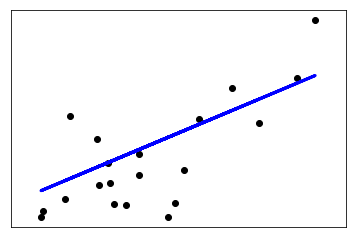

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model

# Load the diabetes dataset
diabetes = datasets.load_diabetes()


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]
print type(diabetes_X)
print shape(diabetes_X)
# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test = diabetes.target[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(diabetes_X_test) - diabetes_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(diabetes_X_test, diabetes_y_test))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, regr.predict(diabetes_X_test), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()